<h1 style="color: darkblue;">Scraped Airbnb Data Overview</h1>

In [1]:
%run parse_html_simulation.py

Listing Title: Luxury Stay at Friday Harbour Resort Lake Simcoe
Sample Price: $175 CAD
Amenities Found:
- Kitchen
- We had a great weekend at Jack’s place! The condo was beautiful, clean and well maintained. The kitchen had all the dishes and utensils we could possibly need. Communicating with Jack was a breeze!
- We had an amazing stay at Jack’s condo in Friday Harbour! The place was spotless, which made me feel right at home. I absolutely loved the decor – it was stylish, modern, and really cozy. The kitchen was fantastic, fully stocked with all the utensils and necessities you could ever need, which made cooking a breeze. We also really appreciated the thoughtful touch of having beer, wine, and snacks available. The location was perfect, with easy access to everything I wanted to explore. Overall, a wonderful experience and I’d highly recommend staying here! 😊
- {"niobeClientData":[["TabbedVerticalHomepage:{\"mockIdentifier\":null,\"skipExtendedSearchParams\":false,\"treatmentFlags\

<h1 style="color: darkblue;">Data Cleaning and Preprocessing</h1>

In [2]:
import pandas as pd

df = pd.read_csv("listings.csv", low_memory=False)
print(df.shape)

df_full = pd.read_csv("listings.csv", low_memory=False)
df_full.columns.tolist()

(21092, 79)


['id',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'source',
 'name',
 'description',
 'neighborhood_overview',
 'picture_url',
 'host_id',
 'host_url',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_listings_count',
 'host_total_listings_count',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'latitude',
 'longitude',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bathrooms_text',
 'bedrooms',
 'beds',
 'amenities',
 'price',
 'minimum_nights',
 'maximum_nights',
 'minimum_minimum_nights',
 'maximum_minimum_nights',
 'minimum_maximum_nights',
 'maximum_maximum_nights',
 'minimum_nights_avg_ntm',
 'maximum_nights_avg_ntm',
 'calendar_updated',
 'has_availability',
 'availability_30

In [3]:
df.head(3)

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,1419,https://www.airbnb.com/rooms/1419,20250609011800,2025-06-18,previous scrape,Beautiful home in amazing area!,"This large, family home is located in one of T...",The apartment is located in the Ossington stri...,https://a0.muscache.com/pictures/76206750/d643...,1565,...,5.00,5.00,5.00,NaN,f,1,1,0,0,0.05
1,8077,https://www.airbnb.com/rooms/8077,20250609011800,2025-06-18,previous scrape,Downtown Harbourfront Private Room,Guest room in a luxury condo with access to al...,NaN,https://a0.muscache.com/pictures/11780344/141c...,22795,...,4.90,4.92,4.83,NaN,f,2,1,1,0,0.88
2,26654,https://www.airbnb.com/rooms/26654,20250609011800,2025-06-18,city scrape,"World Class @ CN Tower, convention centre, The...","CN Tower, TIFF Bell Lightbox, Metro Convention...",There's a reason they call it the Entertainmen...,https://a0.muscache.com/pictures/81811785/5dcd...,113345,...,4.78,4.87,4.69,NaN,f,4,4,0,0,0.26


In [4]:
df['price'] = df['price'].replace(to_replace=r'[\$,]', value='', regex=True)
df['price'] = pd.to_numeric(df['price'], errors='coerce')

df = df[df['price'].notnull()]
df = df[df['price'] > 0]

import ast

df['amenities'] = df['amenities'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])

columns_to_keep = [
    'id', 'name', 'host_name', 'host_since', 'host_is_superhost',
    'neighbourhood_cleansed', 'room_type', 'price', 'description',
    'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'property_type',
    'availability_365', 'amenities', 'latitude', 'longitude', 'review_scores_rating', 'last_review', 'accommodates'
]

df = df[columns_to_keep]

df.isnull().sum()

id                           0
name                         0
host_name                    5
host_since                   6
host_is_superhost          603
neighbourhood_cleansed       0
room_type                    0
price                        0
description                216
minimum_nights               0
number_of_reviews            0
reviews_per_month         3328
property_type                0
availability_365             0
amenities                    0
latitude                     0
longitude                    0
review_scores_rating      3328
last_review               3328
accommodates                 0
dtype: int64

In [5]:
df['host_name'] = df['host_name'].fillna("Unknown")

df['reviews_per_month'] = df['reviews_per_month'].fillna(0)

df = df[df['review_scores_rating'].notnull()]

<h1 style="color: darkblue;">Feature Engineering</h1>

In [6]:
#Occupancy rate
df['occupancy_rate'] = 1 - (df['availability_365'] / 365)

#Amenity Score
key_amenities = ['Wifi', 'Kitchen', 'Free parking on premises', 'Air conditioning', 'Hot tub', 'Pool', 'Heating', 'Essentials', 'Pets allowed']

def calculate_amenity_score(amenities_list):
    score = sum(1 for amenity in key_amenities if amenity in amenities_list)
    return score

df['amenity_score'] = df['amenities'].apply(calculate_amenity_score)

#Price Per Review
df['price_per_review'] = df['price'] / (df['number_of_reviews'] + 1)

#Host Experience
df['host_since'] = pd.to_datetime(df['host_since'], errors='coerce')
df['host_tenure_years'] = (pd.to_datetime('today') - df['host_since']).dt.days / 365

#Superhost Status
df['is_superhost'] = df['host_is_superhost'].map({'t': 1, 'f': 0})

#Review Recency
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')
df['days_since_last_review'] = (pd.to_datetime('today') - df['last_review']).dt.days

#Price per Person
df['price_per_person'] = df['price'] / df['accommodates']

<h1 style="color: darkblue;">Exploratory Data Analysis (EDA)</h1>

In [7]:
df_eda = df.dropna(subset=[
    'price', 'amenity_score', 'occupancy_rate', 'is_superhost',
    'review_scores_rating', 'host_tenure_years', 'price_per_person'
])

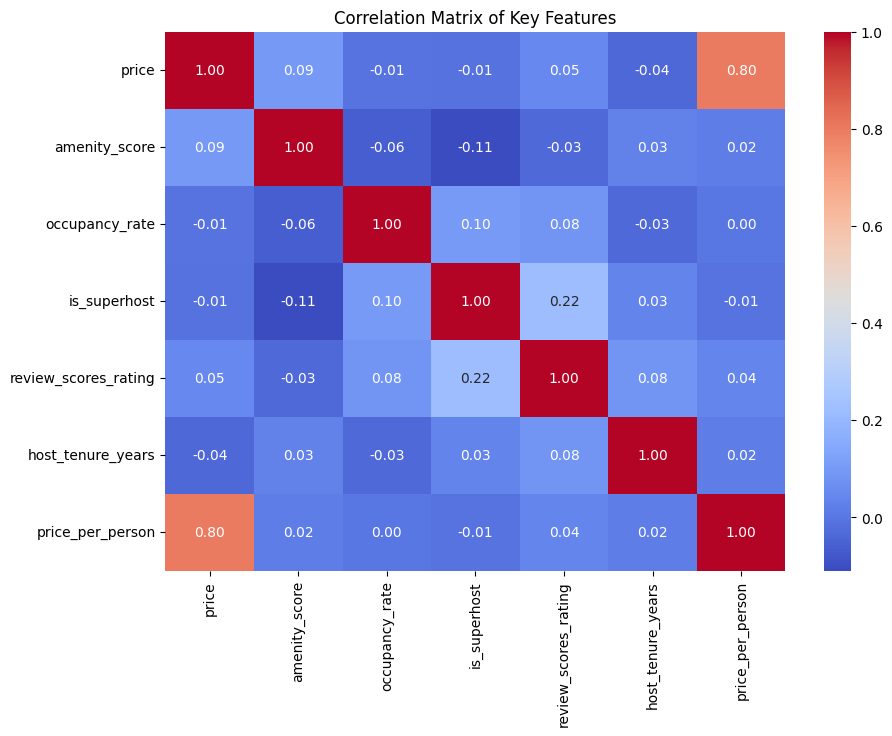

In [8]:
#Correlation Matrix

import seaborn as sns
import matplotlib.pyplot as plt

features = [
    'price', 'amenity_score', 'occupancy_rate', 'is_superhost',
    'review_scores_rating', 'host_tenure_years', 'price_per_person'
]

plt.figure(figsize=(10, 7))
corr = df_eda[features].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Key Features')
plt.show()


In [9]:
#Superhost Premium & Occupancy

import scipy.stats as stats

superhost_stats = df_eda.groupby('is_superhost')[['price', 'occupancy_rate']].mean()
print("Average Price and Occupancy Rate by Superhost Status:\n", superhost_stats)

price_ttest = stats.ttest_ind(
    df_eda[df_eda['is_superhost'] == 1]['price'],
    df_eda[df_eda['is_superhost'] == 0]['price'],
    equal_var=False
)
occupancy_ttest = stats.ttest_ind(
    df_eda[df_eda['is_superhost'] == 1]['occupancy_rate'],
    df_eda[df_eda['is_superhost'] == 0]['occupancy_rate'],
    equal_var=False
)

print(f"T-test for price difference: p-value={price_ttest.pvalue:.4f}")
print(f"T-test for occupancy difference: p-value={occupancy_ttest.pvalue:.4f}")


Average Price and Occupancy Rate by Superhost Status:
                    price  occupancy_rate
is_superhost                            
0.0           189.117210        0.426327
1.0           183.157115        0.489405
T-test for price difference: p-value=0.2263
T-test for occupancy difference: p-value=0.0000


C:\Users\myblu\AppData\Local\Temp\ipykernel_23504\3063548888.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eda[amenity+'_present'] = df_eda['amenities'].apply(lambda x: amenity in x)
C:\Users\myblu\AppData\Local\Temp\ipykernel_23504\3063548888.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eda[amenity+'_present'] = df_eda['amenities'].apply(lambda x: amenity in x)
C:\Users\myblu\AppData\Local\Temp\ipykernel_23504\3063548888.py:6: SettingWithCopyWarning: 
A value is trying to be set on a cop

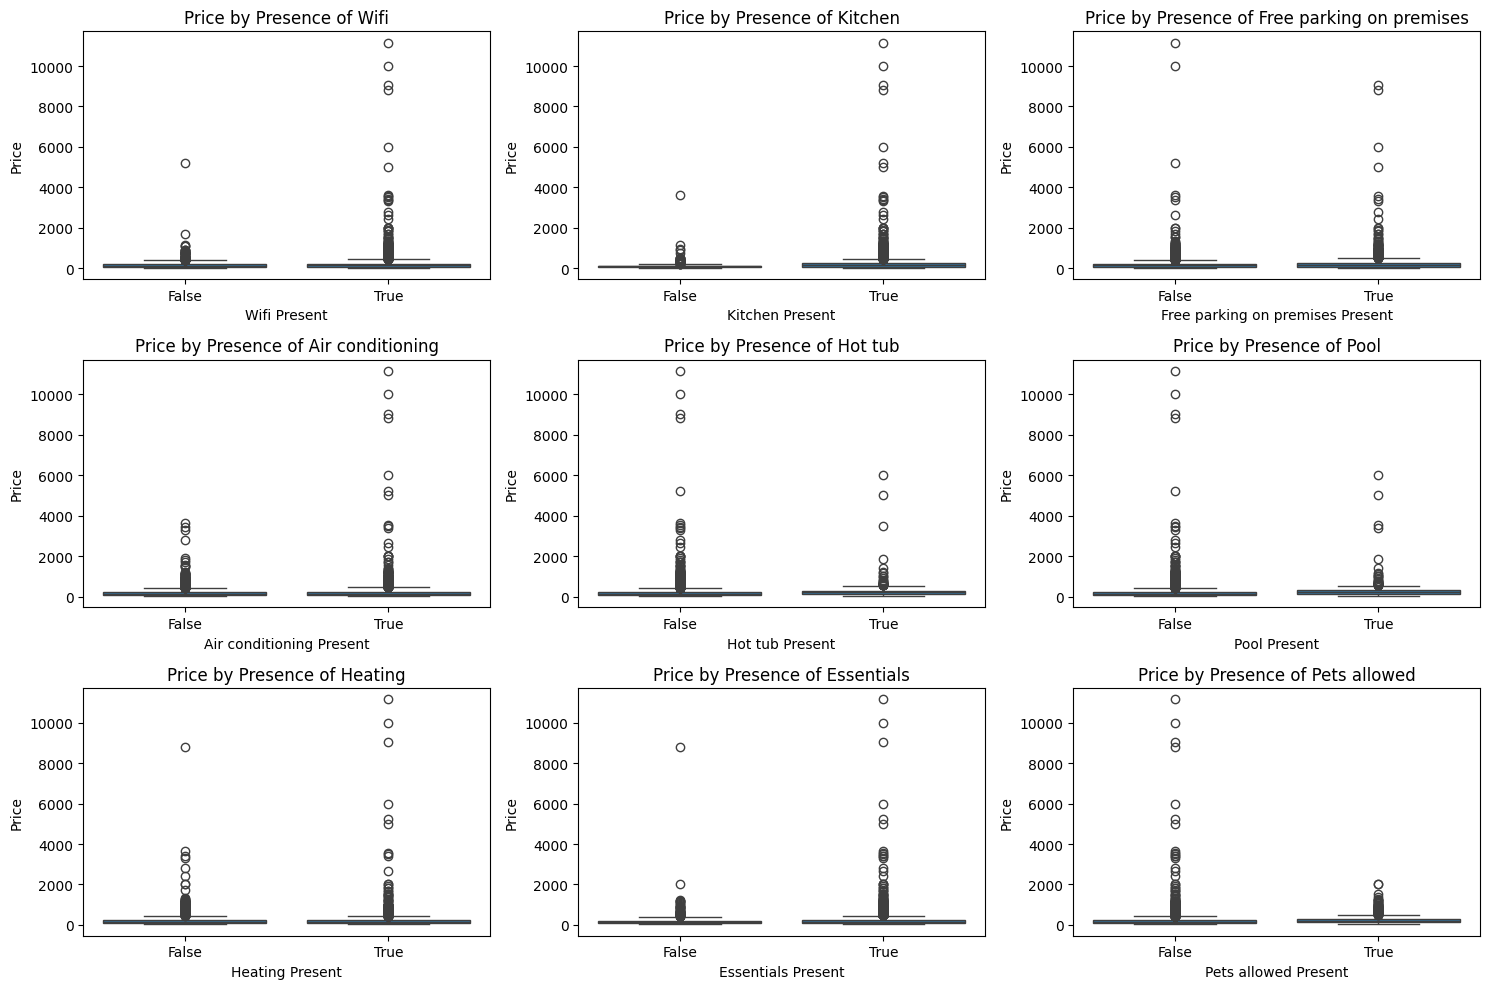

In [10]:
#Price vs Amenities

plt.figure(figsize=(15, 10))
for i, amenity in enumerate(key_amenities):
    plt.subplot(3, 3, i+1)
    df_eda[amenity+'_present'] = df_eda['amenities'].apply(lambda x: amenity in x)
    sns.boxplot(x=amenity+'_present', y='price', data=df_eda)
    plt.title(f'Price by Presence of {amenity}')
    plt.xlabel(f'{amenity} Present')
    plt.ylabel('Price')
plt.tight_layout()
plt.show()

Top 10 Neighborhoods by Occupancy Rate:
     neighbourhood_cleansed  occupancy_rate
14             Blake-Jones        0.606955
57                 Ionview        0.581399
76                Milliken        0.567756
96    Pelmo Park-Humberlea        0.555556
88         North Riverdale        0.554128
66      Lambton Baby Point        0.549863
89     North St.James Town        0.543257
70      Leaside-Bennington        0.538432
55              Humbermede        0.538014
136         Yonge-Eglinton        0.537369

Top 10 Neighborhoods by Best Price/Occupancy Ratio:
       neighbourhood_cleansed  price_occupancy_ratio
55                Humbermede             119.885423
138  York University Heights             139.447657
45    Glenfield-Jane Heights             151.486731
57                   Ionview             156.428571
98             Pleasant View             157.572090
18       Brookhaven-Amesbury             167.494987
76                  Milliken             168.499753
112             

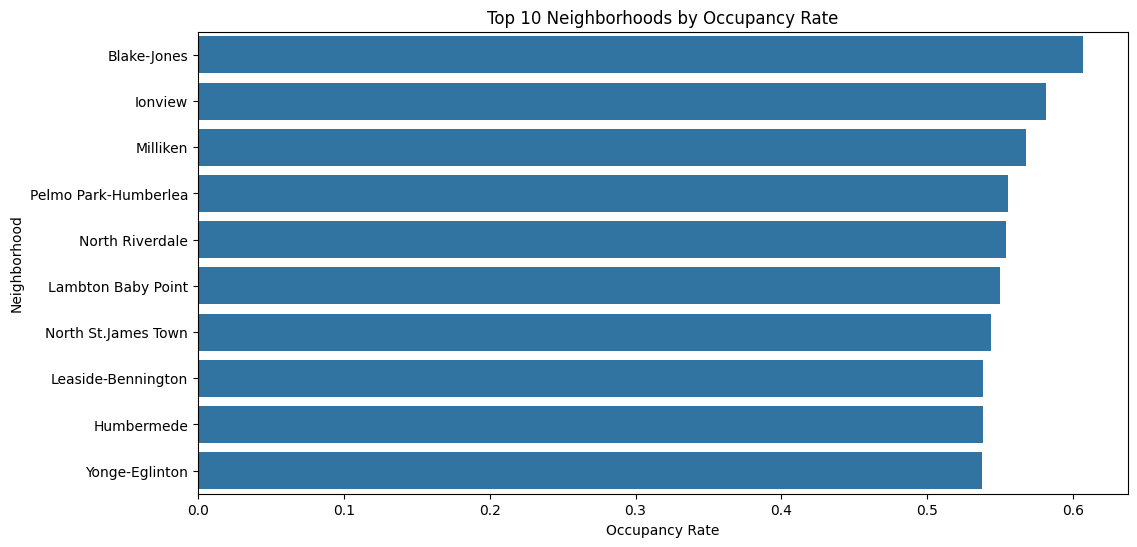

In [11]:
#Occupancy & Price by Neighborhood

neighborhood_summary = df_eda.groupby('neighbourhood_cleansed').agg({
    'occupancy_rate': 'mean',
    'price': 'mean'
}).reset_index()

# Calculating price to occupancy ratio for identifying best neighborhoods
neighborhood_summary['price_occupancy_ratio'] = neighborhood_summary['price'] / neighborhood_summary['occupancy_rate']

top_occupancy = neighborhood_summary.sort_values('occupancy_rate', ascending=False).head(10)
print("Top 10 Neighborhoods by Occupancy Rate:\n", top_occupancy[['neighbourhood_cleansed', 'occupancy_rate']])

top_value = neighborhood_summary.sort_values('price_occupancy_ratio').head(10)
print("\nTop 10 Neighborhoods by Best Price/Occupancy Ratio:\n", top_value[['neighbourhood_cleansed', 'price_occupancy_ratio']])

plt.figure(figsize=(12, 6))
sns.barplot(y='neighbourhood_cleansed', x='occupancy_rate', data=top_occupancy)
plt.title('Top 10 Neighborhoods by Occupancy Rate')
plt.xlabel('Occupancy Rate')
plt.ylabel('Neighborhood')
plt.show()


Superhost vs Non-superhost comparison:
    is_superhost       price  occupancy_rate  review_scores_rating  \
0           0.0  189.117210        0.426327              4.720385   
1           1.0  183.157115        0.489405              4.879481   

   host_tenure_years  
0           6.653152  
1           6.922360  


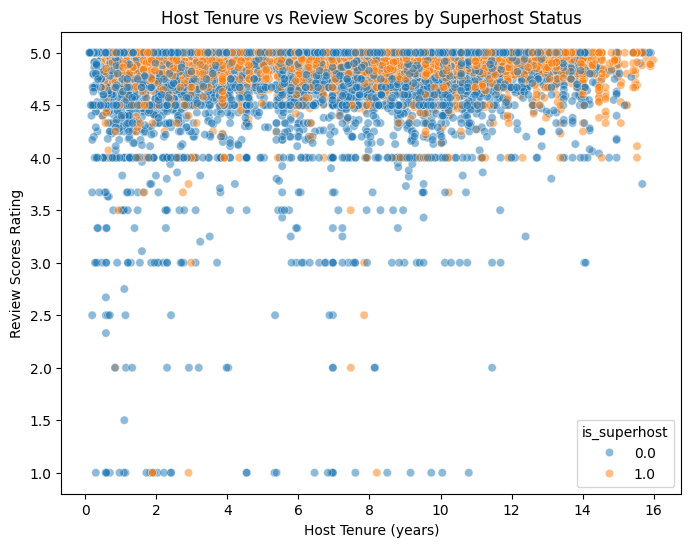

In [12]:
#superhosts vs non-superhosts
host_compare = df_eda.groupby('is_superhost').agg({
    'price': 'mean',
    'occupancy_rate': 'mean',
    'review_scores_rating': 'mean',
    'host_tenure_years': 'mean'
}).reset_index()
print("Superhost vs Non-superhost comparison:\n", host_compare)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='host_tenure_years', y='review_scores_rating', hue='is_superhost',
    data=df_eda, alpha=0.5
)
plt.title('Host Tenure vs Review Scores by Superhost Status')
plt.xlabel('Host Tenure (years)')
plt.ylabel('Review Scores Rating')
plt.show()


Top 20 Property Types by Count:
 property_type
Entire rental unit                   2816
Private room in home                 2406
Entire condo                         2058
Entire home                          1857
Entire guest suite                    569
Private room in rental unit           422
Private room in bungalow              215
Private room in condo                 212
Private room in townhouse             207
Entire townhouse                      152
Entire bungalow                       118
Entire loft                           113
Private room in guest suite            86
Entire guesthouse                      82
Private room in villa                  30
Private room in bed and breakfast      27
Entire serviced apartment              26
Room in hotel                          24
Private room in guesthouse             13
Private room                           12
Name: count, dtype: int64
Top 10 Property Types Price & Occupancy:
                  property_type       price  o

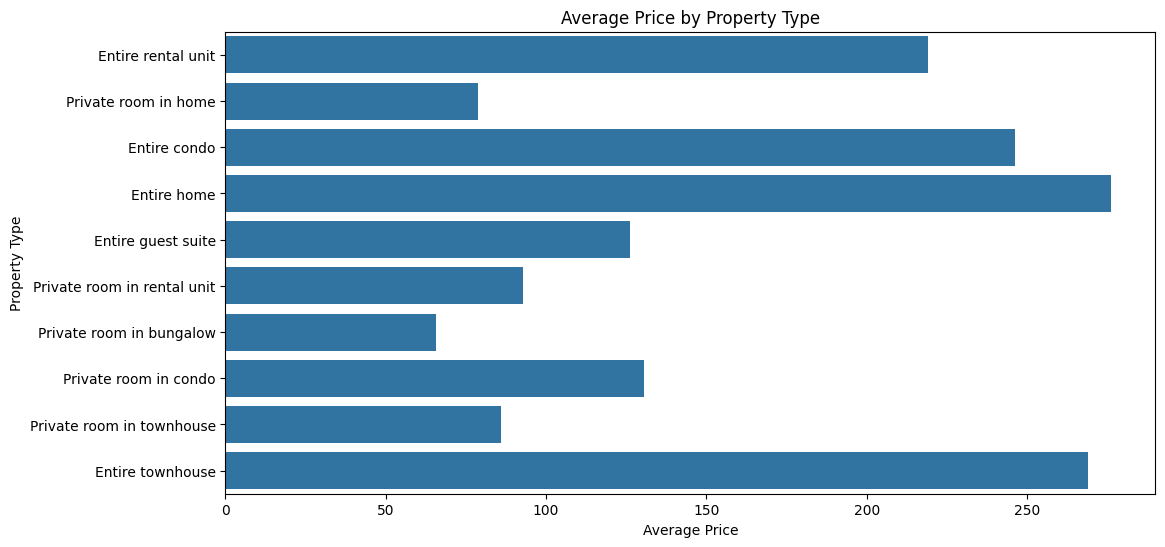

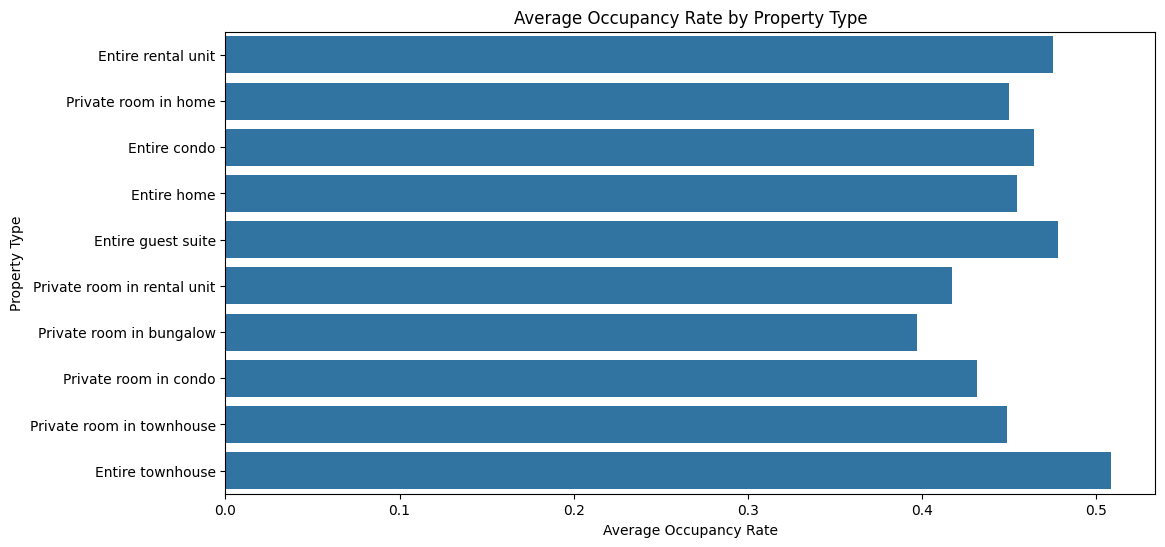

In [13]:
#Unique property types

property_counts = df_eda['property_type'].value_counts().head(20)
print("Top 20 Property Types by Count:\n", property_counts)

property_summary = df_eda.groupby('property_type').agg({
    'price': 'mean',
    'occupancy_rate': 'mean'
}).loc[property_counts.index].head(10).reset_index()

print("Top 10 Property Types Price & Occupancy:\n", property_summary)

plt.figure(figsize=(12, 6))
sns.barplot(x='price', y='property_type', data=property_summary)
plt.title('Average Price by Property Type')
plt.xlabel('Average Price')
plt.ylabel('Property Type')
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='occupancy_rate', y='property_type', data=property_summary)
plt.title('Average Occupancy Rate by Property Type')
plt.xlabel('Average Occupancy Rate')
plt.ylabel('Property Type')
plt.show()


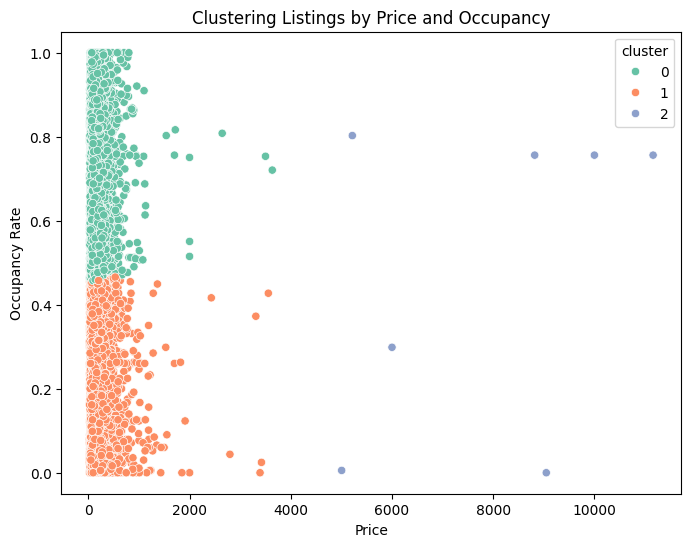

In [14]:
#Clustering Listings by Price and Occupancy

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

cluster_df = df[['price', 'occupancy_rate']].dropna()

scaler = StandardScaler()
scaled = scaler.fit_transform(cluster_df)

kmeans = KMeans(n_clusters=3, random_state=42)
cluster_df['cluster'] = kmeans.fit_predict(scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=cluster_df['price'],
    y=cluster_df['occupancy_rate'],
    hue=cluster_df['cluster'],
    palette='Set2'
)
plt.title("Clustering Listings by Price and Occupancy")
plt.xlabel("Price")
plt.ylabel("Occupancy Rate")
plt.show()


C:\Users\myblu\AppData\Local\Temp\ipykernel_23504\597253357.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_zoom['cluster'] = kmeans_zoom.fit_predict(scaled_zoom)


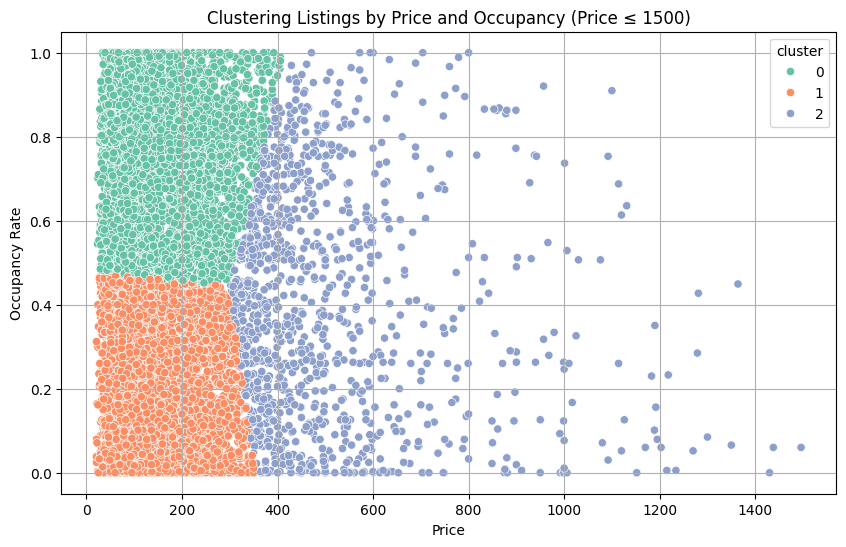

In [15]:
df_zoom = df[(df['price'] <= 1500) & (df['price'] > 0) & (df['occupancy_rate'].notnull())]

X_zoom = df_zoom[['price', 'occupancy_rate']]
scaled_zoom = StandardScaler().fit_transform(X_zoom)

kmeans_zoom = KMeans(n_clusters=3, random_state=42)
df_zoom['cluster'] = kmeans_zoom.fit_predict(scaled_zoom)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_zoom, x='price', y='occupancy_rate', hue='cluster', palette='Set2')
plt.title("Clustering Listings by Price and Occupancy (Price ≤ 1500)")
plt.xlabel("Price")
plt.ylabel("Occupancy Rate")
plt.grid(True)
plt.show()

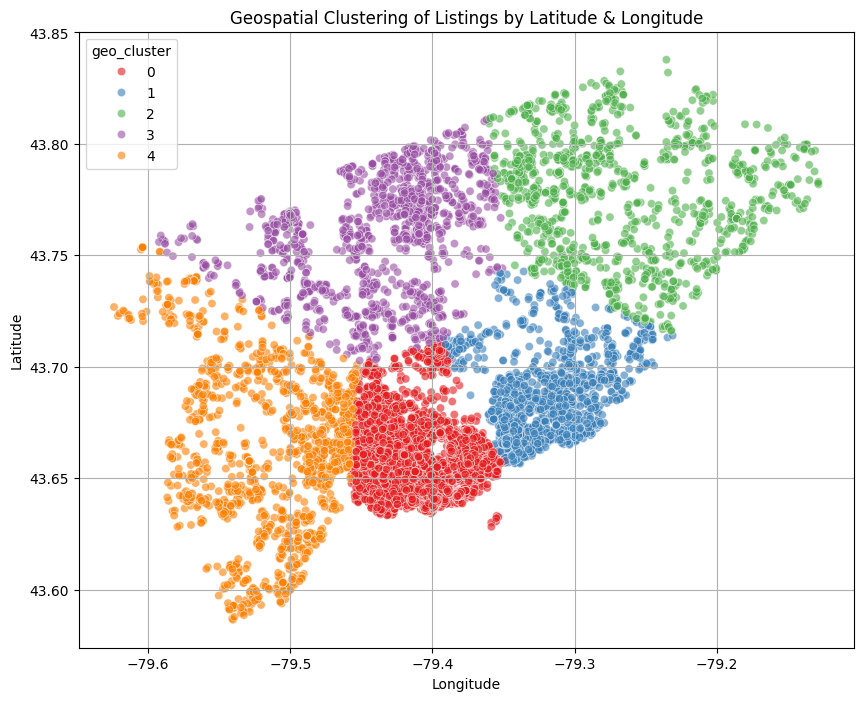

In [16]:
# Geospatial Clustering
df_geo = df.dropna(subset=['latitude', 'longitude'])

X_geo = df_geo[['latitude', 'longitude']]
scaled_geo = StandardScaler().fit_transform(X_geo)

kmeans_geo = KMeans(n_clusters=5, random_state=42)
df_geo['geo_cluster'] = kmeans_geo.fit_predict(scaled_geo)

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='longitude', y='latitude',
    hue='geo_cluster', data=df_geo,
    palette='Set1', alpha=0.6
)
plt.title("Geospatial Clustering of Listings by Latitude & Longitude")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

In [17]:
#Text Analysis on Descriptions

from collections import Counter
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

# Combining all descriptions
all_desc = ' '.join(df['description'].dropna().astype(str))

tokens = re.findall(r'\b\w+\b', all_desc.lower())
tokens = [word for word in tokens if word not in stop_words and len(word) > 2]

word_freq = Counter(tokens)
common_words = word_freq.most_common(20)
print("Top 20 words in descriptions:\n", common_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\myblu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Top 20 words in descriptions:
 [('toronto', 8443), ('located', 5190), ('walk', 4770), ('downtown', 4656), ('bedroom', 4287), ('home', 4160), ('private', 4086), ('restaurants', 3853), ('room', 3842), ('kitchen', 3824), ('enjoy', 3285), ('city', 3226), ('subway', 3162), ('stay', 3085), ('away', 3007), ('station', 3007), ('parking', 2957), ('bed', 2933), ('minutes', 2895), ('space', 2710)]


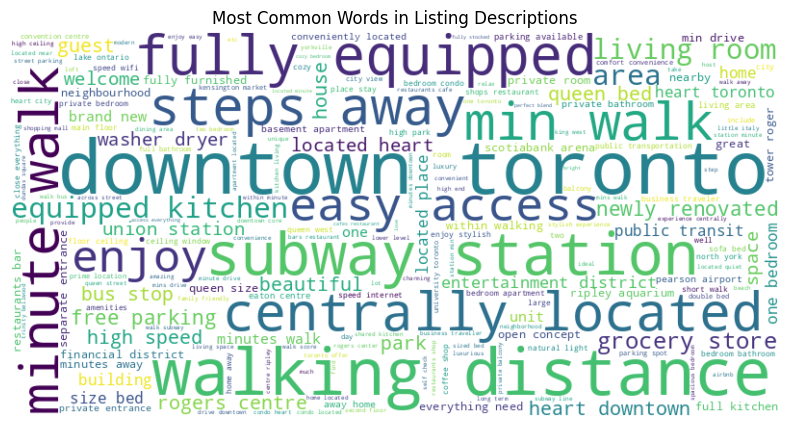

In [18]:
#Word Cloud

from wordcloud import WordCloud

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white'
).generate(' '.join(tokens))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words in Listing Descriptions")
plt.show()


In [23]:
# exporting 'listings_cleaned' for powerbi
if 'cluster' not in df.columns and 'cluster' in df_zoom.columns:
    df = df.merge(df_zoom[['id', 'cluster']], on='id', how='left')

if 'geo_cluster' not in df.columns and 'geo_cluster' in df_geo.columns:
    df = df.merge(df_geo[['id', 'geo_cluster']], on='id', how='left')

export_cols = [
    'id', 'name', 'host_name', 'host_is_superhost', 'host_tenure_years',
    'neighbourhood_cleansed', 'room_type', 'price', 'price_per_person',
    'amenity_score', 'occupancy_rate', 'review_scores_rating',
    'cluster', 'geo_cluster', 'latitude', 'longitude'
]

available_cols = [col for col in export_cols if col in df.columns]

df[available_cols].to_csv("listings_cleaned.csv", index=False)
print("✅ Exported cleaned data to listings_cleaned.csv")


✅ Exported cleaned data to listings_cleaned.csv
